Author: Zidong Chen<br />
Date: 2021/10/12<br />
Acknowledgement: This idea is from Wei W. Xing (wxing.me)<br />
Introduction: This notebook is to show how to use eigen decomposition to solve the non-positive definite problem in Gaussian Process (GP) regression.

In [7]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import os
from kernel import ARDKernel
import GP_CommonCalculation as GP
import importlib
importlib.reload(GP)

<module 'GP_CommonCalculation' from 'D:\\iceLab\\GP_CommonCalculation.py'>

In [8]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

### 核心思想

在训练过程中，有时会遇到Cholesky分解报错的情况，这是由于矩阵非正定（not positive definite）引起的。为了解决这个问题，我们采用特征分解（Eigen decomposition）的方式，通过移除特征值较小的部分来重新构造一个正定矩阵。

### 特征分解

设核矩阵 $K$ 为：

$$ K = Q \Lambda Q^T $$

其中：
- $Q$ 是特征向量矩阵。
- $\Lambda$ 是特征值对角矩阵。

### 处理小特征值

为了确保矩阵正定，我们将特征值中小于 $1 \times 10^{-4}$ 的部分移除。具体步骤如下：

1. **特征分解**：对矩阵 $K$ 进行特征分解，得到特征值和特征向量。
2. **移除小特征值**：将特征值中小于 $1 \times 10^{-4}$ 的部分移除，同时移除对应的特征向量。
3. **重构矩阵**：使用剩余的特征值和特征向量重构矩阵。

### 计算逆矩阵和行列式

重构后的矩阵 $K_{\text{new}}$ 可表示为：

$$ K_{\text{new}} = Q_{\text{new}} \Lambda_{\text{new}} Q_{\text{new}}^T $$

其中 $\Lambda_{\text{new}}$ 和 $Q_{\text{new}}$ 分别是移除小特征值和对应特征向量后的特征值和特征向量矩阵。

#### 计算逆矩阵

$$ K_{\text{new}}^{-1} = Q_{\text{new}} \Lambda_{\text{new}}^{-1} Q_{\text{new}}^T $$

#### 计算行列式的对数

$$ \log \det K_{\text{new}} = \sum_{i} \log \lambda_{i,\text{new}} $$

其中 $\lambda_{i,\text{new}}$ 是重构后的特征值。

### 负对数似然

负对数似然（NLL）的计算公式为：

$$ \text{NLL} = \frac{1}{2} \left( \mathbf{y}^T K_{\text{new}}^{-1} \mathbf{y} + \log \det K_{\text{new}} + n \log 2\pi \right) $$


In [13]:
# implement eigendecomposition
def compute_inverse_and_log_det_positive_eigen(matrix):
    """
    Perform eigen decomposition, remove non-positive eigenvalues,
    and compute the inverse matrix and the log determinant of the matrix.
    
    Parameters:
    matrix (torch.Tensor): Input matrix for decomposition.
    
    Returns:
    torch.Tensor: Inverse of the matrix with non-positive eigenvalues removed.
    torch.Tensor: Log determinant of the matrix with non-positive eigenvalues removed.
    """
    eigenvalues, eigenvectors = torch.linalg.eig(matrix)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real
    #print(eigenvalues)
    positive_indices = eigenvalues > 1e-4
    removed_count = torch.sum(~positive_indices).item()
    #if removed_count > 0:
        #print(f"Removed {removed_count} small or non-positive eigenvalue(s).")
    eigenvalues = eigenvalues[positive_indices]
    eigenvectors = eigenvectors[:, positive_indices]
    inv_eigenvalues = torch.diag(1.0 / eigenvalues)
    inverse_matrix = eigenvectors @ inv_eigenvalues @ eigenvectors.T
    log_det_K = torch.sum(torch.log(eigenvalues))
    return inverse_matrix, log_det_K

In [14]:
#用上述模块搭建蕴含这种计算方法的cigp
class cigp(nn.Module):
    def __init__(self, X, Y, normal_y_mode=0):
        # normal_y_mode = 0: normalize Y by combing all dimension.
        # normal_y_mode = 1: normalize Y by each dimension.
        super(cigp, self).__init__()
        self.kernel = ARDKernel(1)
        #normalize X independently for each dimension
        self.data = GP.XYdata_normalization(X, Y, normal_y_mode)
        self.X, self.Y = self.data.normalize(X, Y)

        # GP hyperparameters
        self.log_beta = nn.Parameter(torch.ones(1) * 0)   # a large noise by default. Smaller value makes larger noise variance.

    def forward(self, Xte):
        Xte = self.data.normalize(Xte)
        Sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(self.X.size(0)) \
                + JITTER * torch.eye(self.X.size(0))

        kx = self.kernel(self.X, Xte)
        kxx = self.kernel(Xte, Xte)
        mean,var= GP.conditional_Gaussian(self.Y, Sigma, kx, kxx)
        var_diag= var.diag().view(-1,1)
        # add the noise uncertainty
        var_diag = var_diag + self.log_beta.exp().pow(-1)
        # de-normalized
        mean, var_diag = self.data.denormalize_result(mean, var_diag)
        return mean, var_diag


    def negative_log_likelihood(self):
        Sigma = self.kernel(self.X, self.X) + self.log_beta.exp().pow(-1) * torch.eye(
            self.X.size(0)) + JITTER * torch.eye(self.X.size(0))
        return  -GP.Gaussian_log_likelihood(self.Y, Sigma)
    
    def negative_log_likelihood_eigen(self):
        y_num, y_dimension = self.Y.shape
        K_xx=self.kernel(self.X,self.X)+JITTER * torch.eye(self.X.size(0))
        K_inv,log_det_K=compute_inverse_and_log_det_positive_eigen(K_xx)
        nll = 0.5 * (self.Y.T @ K_inv @ self.Y + log_det_K + y_num * torch.log(2 * torch.tensor(torch.pi)))
        return nll
        
    def train_adam(self, niteration=10, lr=0.1, loss_type='nll'):
        # adam optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for i in range(niteration):
            optimizer.zero_grad()
            if loss_type == 'nll':
                loss = self.negative_log_likelihood()
            elif loss_type == 'eigen_nll':
                loss = self.negative_log_likelihood_eigen()
            else:
                raise ValueError("Invalid loss_type. Use 'nll' or 'eigen_nll'.")
            
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f'iter {i}, nll: {loss.item():.5f}')

xtr.size: torch.Size([100, 1]) ytr.size: torch.Size([100, 1])
xte.size: torch.Size([100, 1]) yte.size: torch.Size([100, 1])


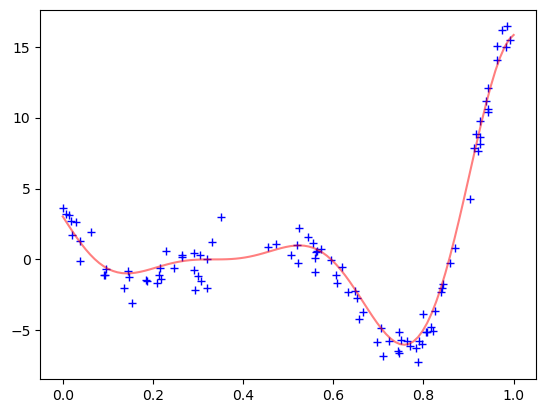

In [15]:
torch.manual_seed(4)
xtr = torch.rand(100, 1)
ytr = ((6*xtr - 2)**2) * torch.sin(12*xtr - 4) + torch.randn(100, 1) * 1

#test_set
xte = torch.linspace(0, 1, 100).view(-1,1)
yte = ((6*xte - 2)**2) * torch.sin(12*xte - 4)

#plot the data
print("xtr.size:", xtr.size(), "ytr.size:", ytr.size())
print("xte.size:", xte.size(), "yte.size:", yte.size())
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.plot(xte.numpy(), yte.numpy(), 'r-', alpha = 0.5)
plt.show()

In [16]:
model1=cigp(xtr,ytr)
model1.train_adam(100,0.01,loss_type='eigen_nll')

iter 0, nll: 1845.78223
iter 10, nll: 1300.46094
iter 20, nll: 378.55664
iter 30, nll: 330.33783
iter 40, nll: 214.56372
iter 50, nll: 170.79425
iter 60, nll: 220.12512
iter 70, nll: 157.59914
iter 80, nll: 131.89536
iter 90, nll: 156.14090


In [17]:
model2=cigp(xtr,ytr)
model2.train_adam(100,0.01,loss_type='nll')

iter 0, nll: 112.97211
iter 10, nll: 105.63551
iter 20, nll: 97.69521
iter 30, nll: 91.15786
iter 40, nll: 85.96370
iter 50, nll: 81.28719
iter 60, nll: 76.91319
iter 70, nll: 72.95862
iter 80, nll: 69.43427
iter 90, nll: 66.28694


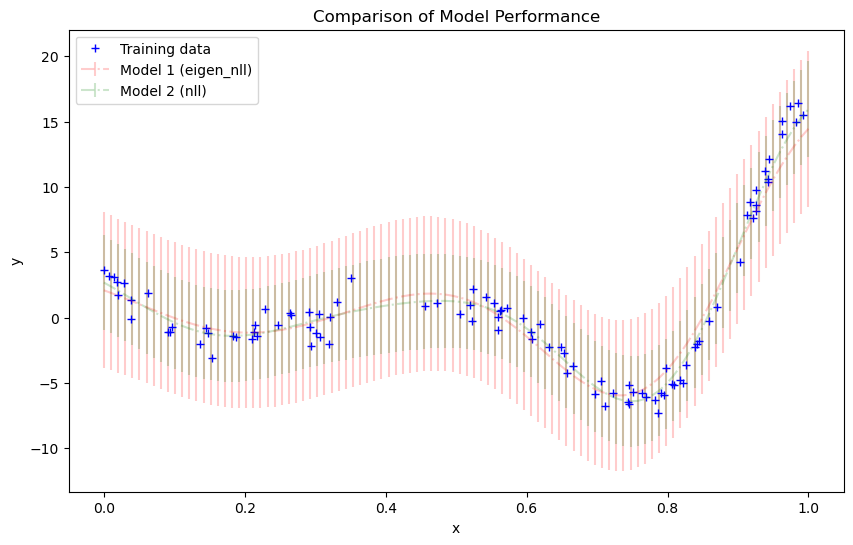

In [25]:
with torch.no_grad():
    ypred1, yvar1 = model1.forward(xte)
    ypred2, yvar2 = model2.forward(xte)
# Plot the results for both models
plt.figure(figsize=(10, 6))

# Plot predictions of the first model
plt.errorbar(xte.numpy().reshape(100), ypred1.detach().numpy().reshape(100),
             yerr=yvar1.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2, label='Model 1 (eigen_nll)')

# Plot predictions of the second model
plt.errorbar(xte.numpy().reshape(100), ypred2.detach().numpy().reshape(100),
             yerr=yvar2.sqrt().squeeze().detach().numpy(), fmt='g-.', alpha=0.2, label='Model 2 (nll)')

# Plot training data points
plt.plot(xtr.numpy(), ytr.numpy(), 'b+', label='Training data')

# Add legend and labels
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Comparison of Model Performance')
plt.show()

In [26]:
def calculate_mse(model, x_test, y_test):
    model.eval()  # 切换模型到评估模式
    with torch.no_grad():  # 关闭梯度计算
        y_pred, _ = model.forward(x_test)  # 获取模型预测输出
        mse_loss = nn.MSELoss()(y_pred, y_test)  # 计算 MSE
    return mse_loss.item()

In [17]:
print(calculate_mse(model1,xte,yte),
calculate_mse(model2,xte,yte))

0.8535208702087402 0.26329904794692993
